# Ensemble of the best models: gaussian_mix, kmeans, clara_opt

Try kmeans + gaussian_mix; kmeans + clara_opt; gaussian_mix + clara_opt; fuzzy + gaussian_mix + ward_link_opt 

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import CLARA
from sklearn.mixture import GaussianMixture
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
df = pd.read_csv('../2_models/with_raw_data/solar/pca_df.csv')
subset_df = pd.read_csv('../2_models/with_raw_data/solar/df_subset.csv')

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

## K-Means with optimized parameters + Gaussian Mix

In [4]:
# K-Means:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Gaussian Mixture:
gmm = GaussianMixture(n_components=7, random_state=1, verbose=1)
gmm_labels = gmm.fit_predict(df)

KMeans is done
Initialization 0
Initialization converged: True


In [5]:
with open('results/raw_solar/gmm.pickle', 'wb') as f:
    pickle.dump(gmm, f)

with open('results/raw_solar/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

Using Major Voting as Ensemble Technique

In [6]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(gmm_labels)))
voting_labels_kmeans_gmm = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    gmm_cluster = gmm_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[gmm_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_gmm[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [7]:
df['cluster_label'] = voting_labels_kmeans_gmm
df['asset_id'] = subset_df['asset_id']

In [8]:
df.to_csv('results/raw_solar/gmm_kmeans.csv', index = False)

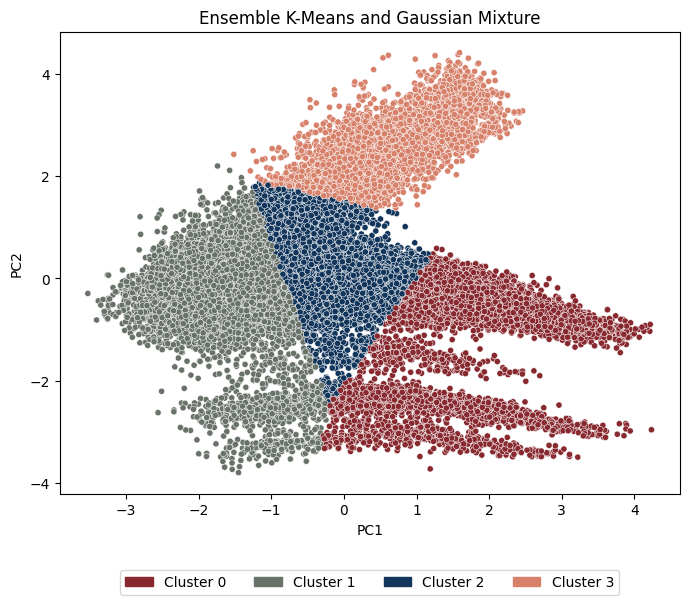

In [9]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble K-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_gmm)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [10]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,0
1,1.722822,-2.602608,11,0
2,1.451641,-2.588719,11,0
3,0.734407,-2.237956,11,0
4,0.121023,-2.182634,11,0


In [11]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,0
1,12,2.651199,-3.422293,0
2,13,1.451020,-0.049027,2
3,14,1.304045,-0.185737,2
4,15,2.222184,-0.592280,2
...,...,...,...,...
72,510,0.207552,2.331831,3
73,511,1.209865,3.228942,3
74,512,-0.236960,0.793759,3
75,513,1.510521,3.365319,3


In [12]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 8, 14, 17, 33, 46, 50, 52, 58]
Cluster 1: [9, 12, 13, 16, 48, 49, 51, 53, 54, 55]
Cluster 2: [2, 3, 4, 5, 6, 7, 10, 11, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 45, 47, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]


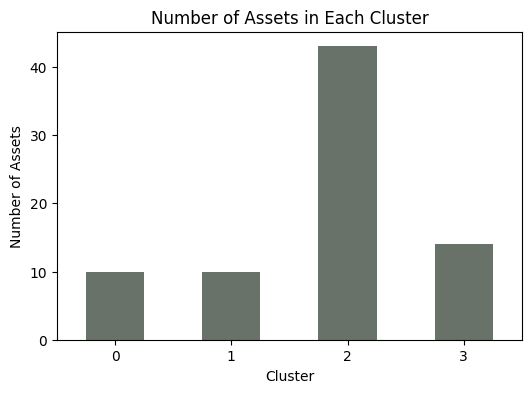

In [13]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [14]:
def dunn_index(points = np.array(df), labels = voting_labels_kmeans_gmm):
    min_intercluster_distances = []
    max_intracluster_distances = []
    
    for label in np.unique(labels):
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intracluster_distances = pairwise_distances(cluster_points)
            max_intracluster_distances.append(np.max(intracluster_distances))
        
        for other_label in np.unique(labels):
            if label != other_label:
                other_cluster_points = points[labels == other_label]
                intercluster_distances = pairwise_distances(cluster_points, other_cluster_points)
                min_intercluster_distances.append(np.min(intercluster_distances))
    
    if len(max_intracluster_distances) == 0 or len(min_intercluster_distances) == 0:
        return 0
    
    return min(min_intercluster_distances) / max(max_intracluster_distances)


In [15]:
def xie_beni_index(points = np.array(df), labels = voting_labels_kmeans_gmm):
    # Compute the total scatter
    total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
    # Compute the intra-cluster scatter
    cluster_labels = np.unique(labels)
    intra_cluster_scatter = 0
    for label in cluster_labels:
        cluster_points = points[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    intra_cluster_scatter /= len(points)
    
    return intra_cluster_scatter / total_scatter


In [16]:
# Define a function to compute evaluation metrics
def compute_metrics(points = np.array(df), labels = voting_labels_kmeans_gmm):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


In [17]:
# Initialize an empty list to store the results
results = []

# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_gmm)
results.append({'Model': 'gmm + kmeans_opt', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [18]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,-0.079402,13.944649,459.640824,0.000012,0.000019


## K-Means + Clara with optimized parameters

In [19]:
df = df[['PC1', 'PC2']]

In [20]:
# K-Means:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

clara = CLARA(n_clusters=3, random_state=1)
clara_labels = clara.fit_predict(df)

KMeans is done


In [21]:
with open('results/raw_solar/clara.pickle', "wb") as f:
    pickle.dump(clara, f)

In [22]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(clara_labels)))
voting_labels_kmeans_clara = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[clara_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [23]:
df['cluster_label'] = voting_labels_kmeans_clara
df['asset_id'] = subset_df['asset_id']

In [24]:
df.to_csv('results/raw_solar/clara_kmeans.csv', index = False)

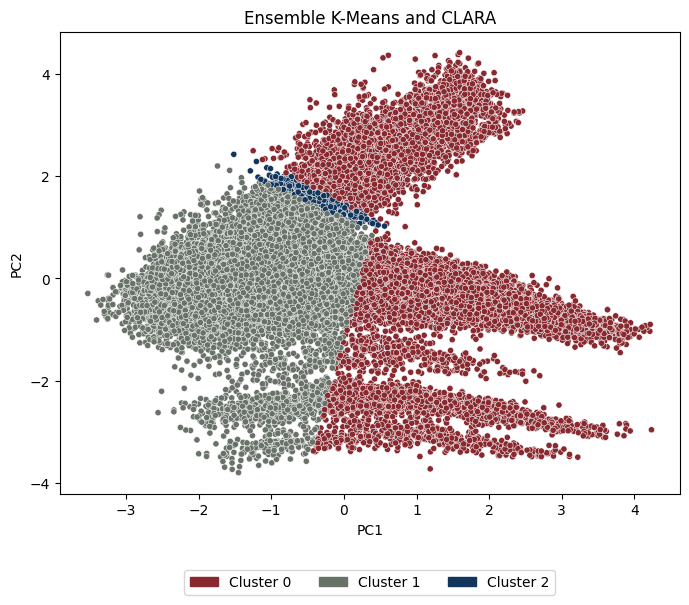

In [25]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble K-Means and CLARA')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_clara)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [26]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,0
1,1.722822,-2.602608,11,0
2,1.451641,-2.588719,11,0
3,0.734407,-2.237956,11,0
4,0.121023,-2.182634,11,0


In [27]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,0
1,12,2.651199,-3.422293,0
2,13,1.451020,-0.049027,1
3,14,1.304045,-0.185737,1
4,15,2.222184,-0.592280,1
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,0
74,512,-0.236960,0.793759,0
75,513,1.510521,3.365319,1


In [28]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 23, 33, 37, 45, 46, 52, 58, 72, 73, 74, 76]
Cluster 1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 75]


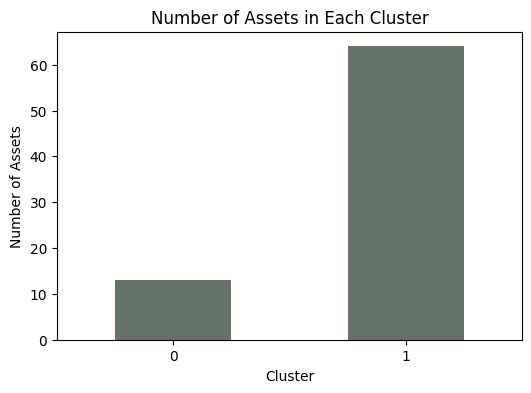

In [29]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [30]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_clara)
results.append({'Model': 'clara + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [31]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,-0.079402,13.944649,459.640824,0.000012,0.000019
1,clara + kmeans,-0.011111,39.287521,28.256997,0.000012,0.000020


## Gaussian Mixture + CLARA

In [32]:
df = df[['PC1', 'PC2']]

In [33]:
# Voting based on cluster assignments
num_clusters = max(len(set(gmm_labels)), len(set(clara_labels)))
voting_labels_gmm_clara = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    gmm_cluster = gmm_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[gmm_cluster] += 1
    votes[clara_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_gmm_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [34]:
df['cluster_label'] = voting_labels_gmm_clara
df['asset_id'] = subset_df['asset_id']

In [35]:
df.to_csv('results/raw_solar/gmm_clara.csv', index = False)

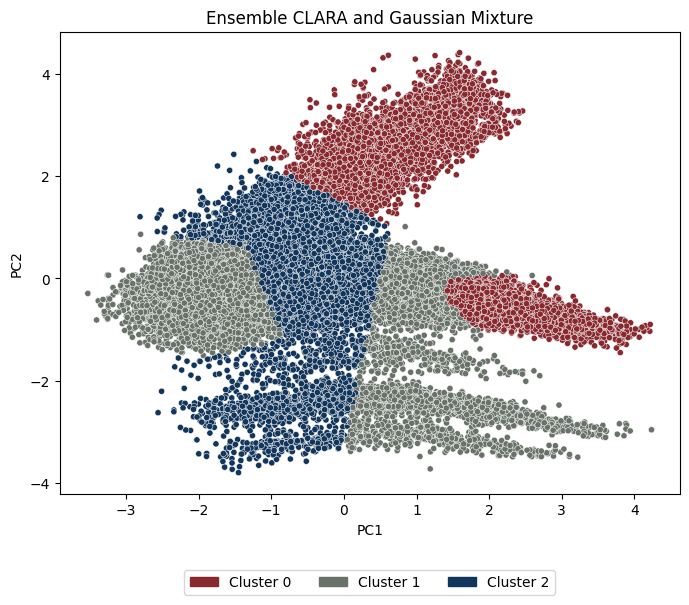

In [36]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble CLARA and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_gmm_clara)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [37]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,1
1,1.722822,-2.602608,11,1
2,1.451641,-2.588719,11,1
3,0.734407,-2.237956,11,1
4,0.121023,-2.182634,11,1


In [38]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,1
1,12,2.651199,-3.422293,1
2,13,1.451020,-0.049027,1
3,14,1.304045,-0.185737,2
4,15,2.222184,-0.592280,1
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,0
74,512,-0.236960,0.793759,0
75,513,1.510521,3.365319,0


In [39]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 1: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 26, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61]
Cluster 2: [3, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 57, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


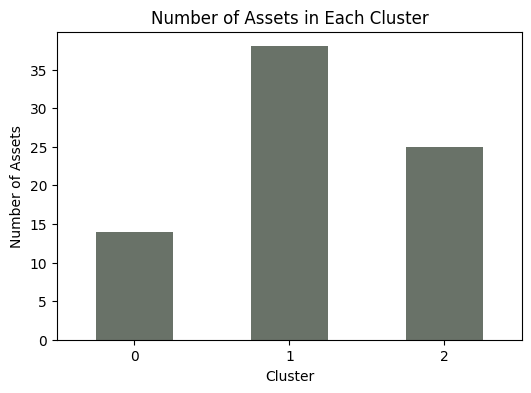

In [40]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [41]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_gmm_clara)
results.append({'Model': 'gmm + clara', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [42]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,-0.079402,13.944649,459.640824,0.000012,0.000019
1,clara + kmeans,-0.011111,39.287521,28.256997,0.000012,0.000020
2,gmm + clara,-0.021666,78.076728,106.636180,0.000024,0.000019


## GMM + K-Means + CLARA

In [43]:
df = df[['PC1', 'PC2']]

In [44]:
voting_labels_all = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    gmm_cluster = gmm_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[gmm_cluster] += 1
    votes[clara_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_all[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [45]:
df['cluster_label'] = voting_labels_all
df['asset_id'] = subset_df['asset_id']

In [46]:
df.to_csv('results/raw_solar/clara_kmeans_gmm.csv', index = False)

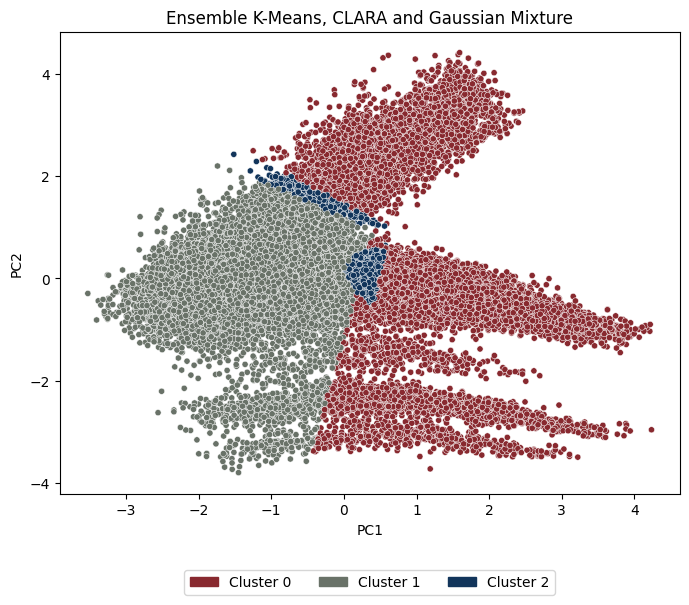

In [47]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Ensemble K-Means, CLARA and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_all)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [48]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,0
1,1.722822,-2.602608,11,0
2,1.451641,-2.588719,11,0
3,0.734407,-2.237956,11,0
4,0.121023,-2.182634,11,0


In [49]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,0
1,12,2.651199,-3.422293,0
2,13,1.451020,-0.049027,1
3,14,1.304045,-0.185737,1
4,15,2.222184,-0.592280,1
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,0
74,512,-0.236960,0.793759,0
75,513,1.510521,3.365319,1


In [50]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 37, 46, 52, 58, 72, 73, 74, 76]
Cluster 1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 75]


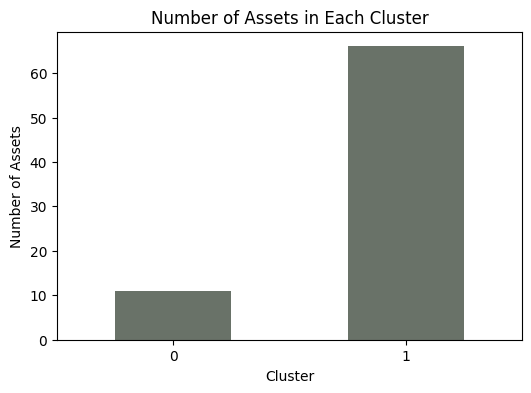

In [51]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [52]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_all)
results.append({'Model': 'clara + kmeans + gmm', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [53]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,gmm + kmeans_opt,-0.079402,13.944649,459.640824,0.000012,0.000019
1,clara + kmeans,-0.011111,39.287521,28.256997,0.000012,0.000020
2,gmm + clara,-0.021666,78.076728,106.636180,0.000024,0.000019
3,clara + kmeans + gmm,-0.018332,46.835654,15.530609,0.000014,0.000020


the best is gmm + clara as clara + kmeans has 3 metrics with better scoring than the gmm + kmeans and the gmm + clara has 2 scores better than clara + kmeans

In [54]:
with open('results/raw_solar/results.pickle', 'wb') as f:
    pickle.dump(results,f)

results_df.to_csv('results/raw_solar/results.csv', index=False)

In [55]:
normalized_df = results_df.copy()

# Define ideal and anti-ideal solutions for each metric
ideal_solution = normalized_df.copy()
anti_ideal_solution = normalized_df.copy()

# Define metrics where higher values are better
higher_is_better = ['Silhouette Score', 'Dunn Index', 'Calinski-Harabasz Index']

# Define metrics where lower values are better
lower_is_better = ['Davies-Bouldin Index', 'Xie-Beni Index']

# Set ideal and anti-ideal solutions for metrics where higher values are better
for metric in higher_is_better:
    ideal_solution[metric] = normalized_df[metric].max()
    anti_ideal_solution[metric] = normalized_df[metric].min()

# Set ideal and anti-ideal solutions for metrics where lower values are better
for metric in lower_is_better:
    ideal_solution[metric] = normalized_df[metric].min()
    anti_ideal_solution[metric] = normalized_df[metric].max()

# Calculate the distance from each alternative to the ideal and anti-ideal solutions
dist_to_ideal = ((normalized_df.iloc[:,1:] - ideal_solution) ** 2).sum(axis=1) ** 0.5
dist_to_anti_ideal = ((normalized_df.iloc[:,1:] - anti_ideal_solution) ** 2).sum(axis=1) ** 0.5

# Calculate the relative closeness to the ideal solution --> the one that has the bigger distance from the anti-ideal solution is the one thats closer to the ideal solution
normalized_df['Closeness'] = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

# Sort the models based on their relative closeness to the ideal solution
ranked_models = normalized_df.sort_values(by='Closeness', ascending=False)

# Print the ranked models
ranked_models[['Model', 'Closeness']]

,Model,Closeness
0,gmm + kmeans_opt,0.999848
2,gmm + clara,0.202507
1,clara + kmeans,0.086317
3,clara + kmeans + gmm,0.065554
